# Model evaluation

It is important to check the performance and reliability of predictive models before using them for real. Model evaluation identifies possible biases in the models and assesses how well models can generalise well to unseen data.

Here I discuss evaluation at two levels: 

* Patient level: Evaluation of patient-level models that predict whether a given patient is admitted or not at the end of their visit
* Aggregate level: Evaluation of bed-level models that predict the number of beds needed with a prediction window

We kept a test set separate from the training data for this purpose. 

### IMPORTANT - ANY MODELS TRAINED USING SYNTHETIC DATA WILL HAVE ARTIFICIALLY INFLATED MODEL PERFORMANCE. IF YOU VIEW THIS NOTEBOOK USING SUCH MODELS, THEY DO NOT REFLECT THE TRUE PERFORMANCE ON REAL PATIENT DATA. 

## 1. Patient-level models

Here I demonstrate the use of: 

a. Standard metrics used in Machine Learning, such as Area Under the Receiver Operator Curve (AUROC, or often referred to as AUC) and logloss. 

b. Calibration plots which shows how well a model's predicted probabilities match actual outcomes. Predicted probabilties are grouped in bins across the range of probabilities from 0 to 1 and compared with the observed proportion of admissions in each bin

c. MAPCAP plots which, like the calibration plot, compare predicted probabilities with numbers of admission. Unlike the calibration plot a MADCAP presents the information in a cumulative manner. Predicted probabilities are ordered from 0 to 1 and admissions are summed cumulatively. MAPCAP stands for Model Accuracy Diagnostic Calibration Plot

## 2. Aggregate level evaluation

There are various approaches. A common approach is to generate a single number such as mean squared error. For this:

a. for each prediction moment, compare the observed number of admissions and the expected value from the probability distribution for the model predictions at that moment. These can be compared, over the whole test set, using Mean Absolute Error (MAE) - which avoids positive and negative deviations cancelling each other out - and the error can also be expressed as a percentage of observed admissions to derive a mean percentage error (MPE).  

b. for each prediction moment, compare the expected value of the probability distribution with a rolling average of six weeks [work in progress]

Other methods appraise the performance of the model across the whole distribution. If a model predicts the tails of a distribution well, the observed number of beds would appear in the lowest tenth of the distribution on 10% of prediction moments, and likewise in the highest tenth on 10% of prediction moments. This is evaluated by:

c. a QQ plot, a tool used to compare one probility distribution with another. The observed values across the test set are treated as a distribution, and compared with predicted distribution

## 3. Evaluating predictions by specialty [work in progress]

We can use the evaluation methods above and break them down by specialty. This is work in progress.

## 4. Evaluating aspirational predictions for patients in ED and yet-to-arrive patients [work in progress]

The methods above are concerned with whether each patient is eventually admitted - but not whether they were admitted within the prediction window of 8 hours. Strictly, this should be done, but this requires additional treatment, because of the aspirational time to admission that is imposed in our approach. 

If we compared our aspirational predictions of admission in 8 hours to the actual numbers admitted in 8 hours, we'd find the models overestimated how many would be admitted in that window, because the ED targets were not being met during the period of the test set. 

The same applies to the yet-to-arrive predictions. At current performance levels, fewer patients would arrive within 8 hours of the prediction moment, and be admitted before the end of 8 hours, than the aspirational models predict. 

Strictly, we should evaluate the aspirational predictions nonetheless, as we are producing output which is sent to bed managers at the 90% and 70% cut points on the cumulative probability distribution, and they would like to be confident that these predictions are fair. 

There is a way to do this. To illustrate, let's assume for a moment that the model always predicts they'll need at least 2 medical beds with 90% probability, and 3 with 70% probability. 

On 90% of days when we make that prediction, the observed number of medical beds needed within 8 hours (after applying the aspirational curve to observed arrivals times) should be 2 or more and on 70% of days it should be 3 or more. 

We can generate such evaluation, with a bit of additional processing. This is work in progress.

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()

Inferred project root: /Users/zellaking/Repos/patientflow


## Load parameters, file paths and data

In [ ]:
import pandas as pd
from patientflow.load import load_data, set_file_paths
from patientflow.prepare import create_temporal_splits


# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(project_root, 
               data_folder_name=data_folder_name)

# load data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]

# get test set from the original data
_, _, test_visits = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)


Configuration will be loaded from: /Users/zellaking/Repos/patientflow/config.yaml
Data files will be loaded from: /Users/zellaking/Repos/patientflow/data-public
Trained models will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public
Images will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public/media
Split sizes: [53801, 6519, 19494]


## 1. Evaluation of the models predicting admission to ED (at individual patient level)

For details of how the modelling was done see notebook [4a_Predict_Probability_of_admission_from_ED.ipynb](4a_Predict_Probability_of_admission_from_ED.ipynb)

### 1a. Standard metrics used in Machine Learning

First I load the performance of the Area Under the Receiver Operator Curve (AUROC or AUC) and the log loss for each prediction time. The results shown are on the test set, using the balanced and calibrated models. 

In [8]:
from patientflow.load import get_model_key
from patientflow.viz.model_comparison import load_model_results, print_model_results
import json

prediction_times = ed_visits.prediction_time.unique()
models = {
    'admissions_balanced_calibrated': 'model_metadata_balanced_calibrated.json'
}
# Loads the saved model results from the model_file_path
results = load_model_results(model_file_path, prediction_times, models)

# Convenience function for printing the results
print_model_results(results, metrics_keys=["test_auc", "test_logloss"])


Results for admissions_balanced_calibrated model

Model: admissions_balanced_calibrated_0600; auc: 0.760; logloss: 0.464 

Model: admissions_balanced_calibrated_0930; auc: 0.771; logloss: 0.370 

Model: admissions_balanced_calibrated_1200; auc: 0.789; logloss: 0.337 

Model: admissions_balanced_calibrated_1530; auc: 0.785; logloss: 0.405 

Model: admissions_balanced_calibrated_2200; auc: 0.835; logloss: 0.411 




As the dataset is imbalanced - many more patients are discharged than admitted - a better metric is the Area under the Precision-Recall Curve (AUPRC). It shows how well the model identifies true positive cases (admissions) while minimizing false positives. The AUPRC score should be higher than the proportion of admissions in the dataset. A higher AUPRC indicates that the model can better identify patients who will need admission while minimising any excess effort to prepare beds for patients who will not be admitted. 

In the results below, the models perform better than a random allocation based on the class balance.

In [9]:
print_model_results(results, metrics_keys=["original_positive_rate", "test_auprc"])


Results for admissions_balanced_calibrated model

Model: admissions_balanced_calibrated_0600; class balance: 0.172; auprc: 0.476 

Model: admissions_balanced_calibrated_0930; class balance: 0.131; auprc: 0.398 

Model: admissions_balanced_calibrated_1200; class balance: 0.124; auprc: 0.422 

Model: admissions_balanced_calibrated_1530; class balance: 0.155; auprc: 0.470 

Model: admissions_balanced_calibrated_2200; class balance: 0.165; auprc: 0.587 




### 1b. Calibration plots

A calibration plot shows how well a model's predicted probabilities match actual outcomes.

- X-axis (Mean Predicted Probability): The model's predicted probabilities, ordered from 0 to 1, grouped into bins, either using the uniform or the quantile strategy (see below).
- Y-axis (Fraction of Positives): The observed proportion of admissions for visits in that group.

A perfectly calibrated model would align its points along the diagonal line, meaning a 70% predicted probability means the event happens 70% of the time.

Uniform vs Quantile Strategies:
- Uniform: Divides predictions into equal-width probability bins (e.g., 0.0-0.1, 0.1-0.2), so some bins may have few or many points.
- Quantile: Ensures each bin has the same number of predictions, regardless of how wide or narrow each bin's probability range is.


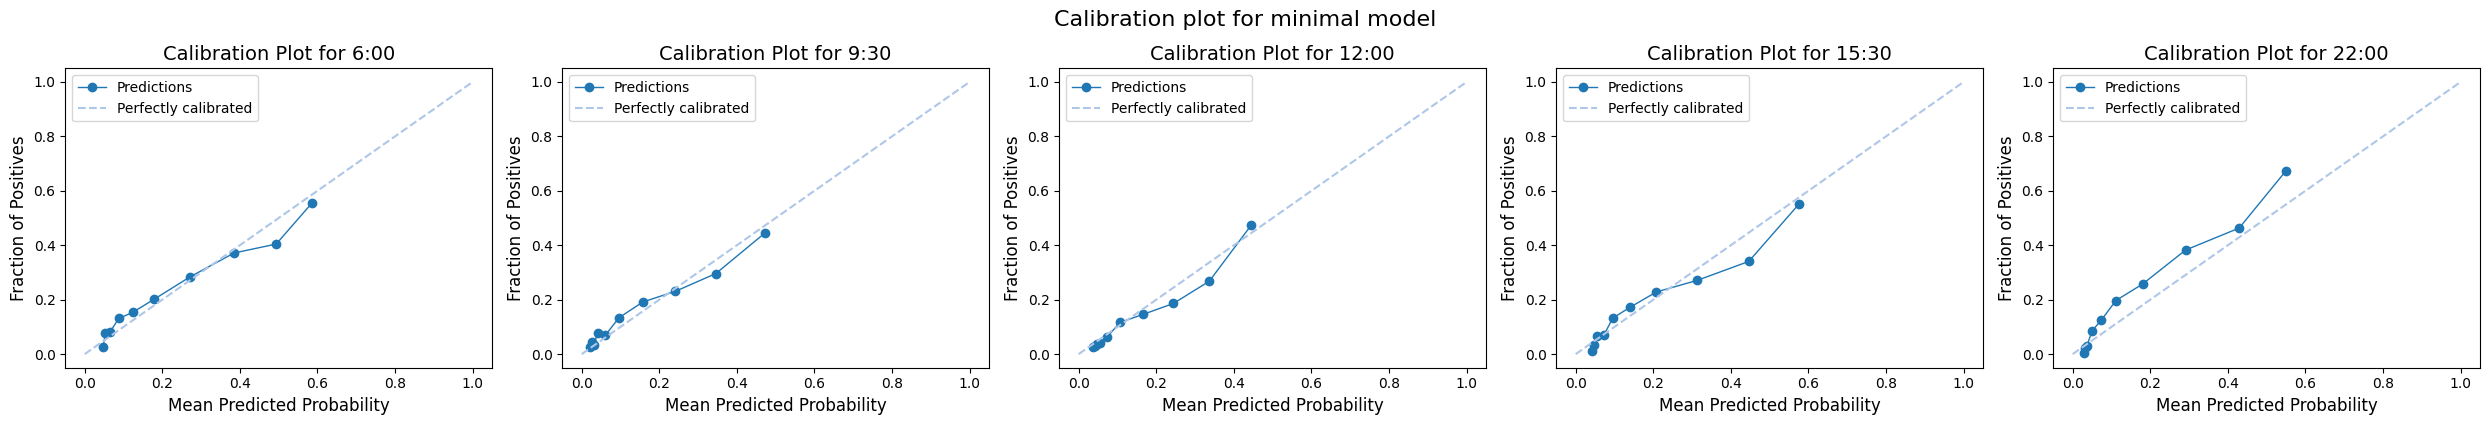

In [15]:
from patientflow.viz.calibration_plot import plot_calibration


exclude_from_training_data = [ 'snapshot_date', 'prediction_time','consultation_sequence', 'visit_number', 'specialty', 'final_sequence', 'training_validation_test']
plot_calibration(
    prediction_times,
    media_file_path,
    trained_models=None,
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data,
    strategy="quantile",
    model_group_name='admissions_balanced_calibrated',
    suptitle="Calibration plot for minimal model",
    model_file_path=model_file_path
)

### 1c .MADCAP plots

A MADCAP (Model Accuracy Diagnostic Calibration Plot) visually compares the predicted probabilities from a model with the actual outcomes (e.g., admissions or events) in a dataset. This plot helps to assess how well the model's predicted probabilities align with the observed values.

The blue line represents the cumulative predicted outcomes, which are derived by summing the predicted probabilities as we move through the test set, ordered by increasing probability.
The orange line represents the cumulative observed outcomes, calculated based on the actual labels in the dataset, averaged over the same sorted order of predicted probabilities.

If the model is well calibrated, these two lines will closely follow each other, and the curves will bow to the bottom left. 

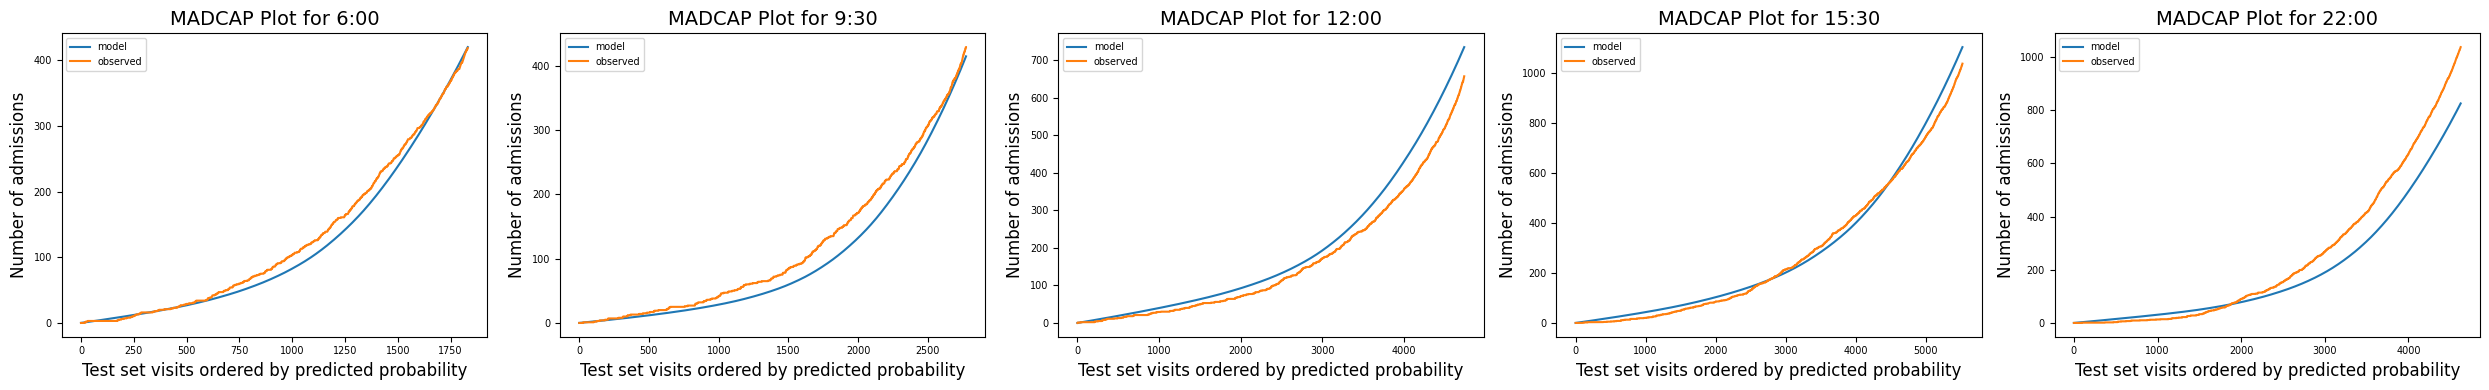

In [16]:
## without balanced training
from patientflow.viz.madcap_plot import generate_madcap_plots
generate_madcap_plots(
    prediction_times,
    media_file_path,
    trained_models=None,
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data,
    model_group_name = "admissions_balanced_calibrated",   
    model_file_path=model_file_path
) 


The plots below are separated into age groups. The models do best for adults, for which there are many more observations than for children, and do better for patients over 65 in the 1200 and 1530 models. 

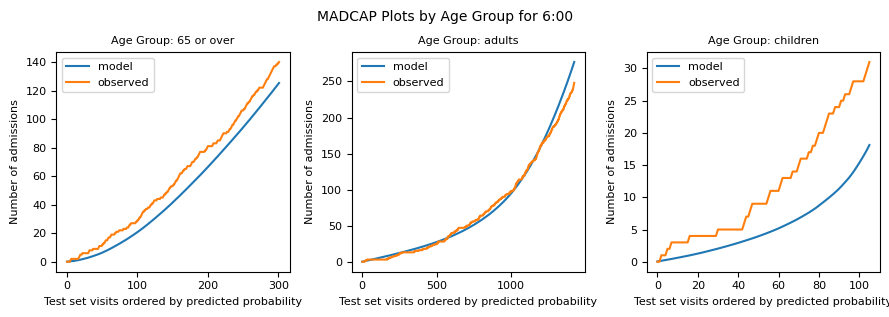

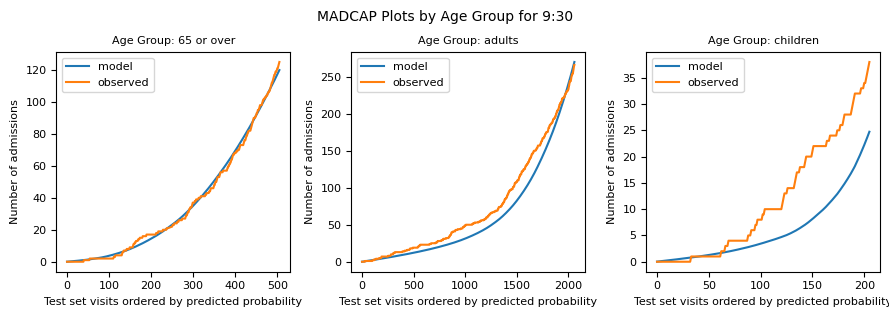

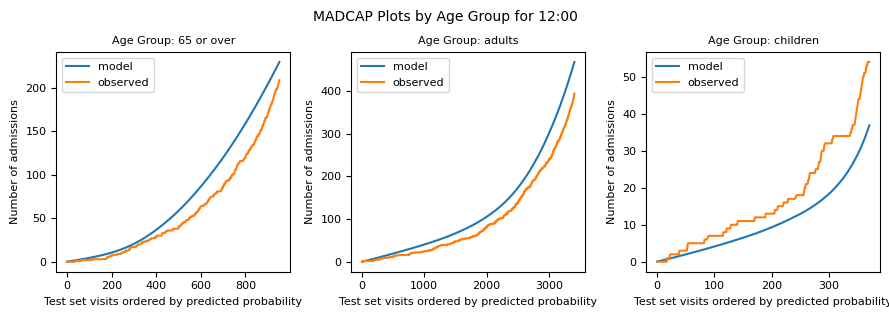

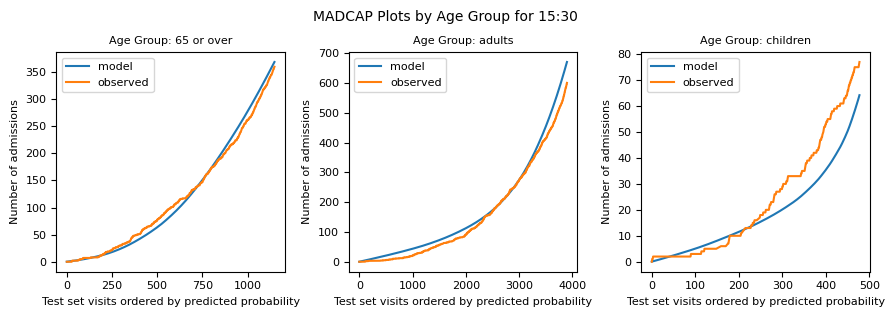

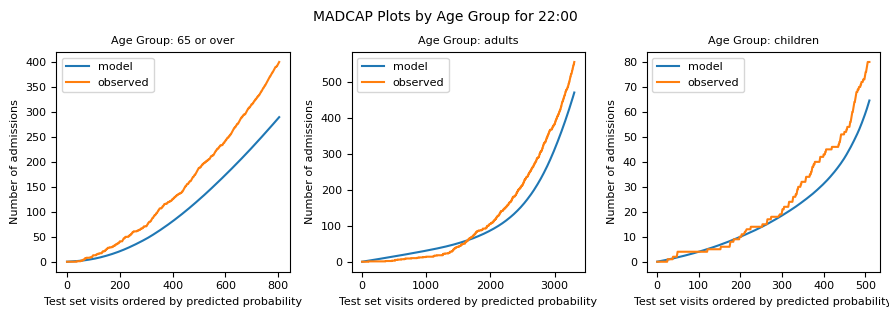

In [17]:
from patientflow.viz.madcap_plot import generate_madcap_plots_by_group
generate_madcap_plots_by_group(
    prediction_times,
    media_file_path,
    trained_models=None,
    test_visits=test_visits,
    exclude_from_training_data=exclude_from_training_data,
    model_group_name = "admissions_balanced_calibrated",
    grouping_var = "age_group",
    grouping_var_name = "Age Group",
    model_file_path=model_file_path
) 


## 2. Evaluation of the models predicting admission to ED (at aggregate level for each snapshot)

As the ultimate objective for these models is to predict bed numbers, not patient-level probability of admission, we need a way to evaluate the aggregate level. 

In order to evaluate the models' performance in aggregate, we first need to iterate through each snapshot date in the test set, creating a dictionary of all the predictions. The dictionary saves a probability distribution for each snapshot date, and the observed number of patients in the ED at that moment, who were actually admitted.




In [21]:
from patientflow.prepare import prepare_for_inference, prepare_group_snapshot_dict
from patientflow.load import get_model_key
from patientflow.aggregate import get_prob_dist

exclude_from_training_data = [ 'snapshot_date', 'prediction_time','consultation_sequence', 'visit_number', 'specialty', 'final_sequence', 'training_validation_test']


prob_dist_dict_all = {}
# Process each time of day
model_name = 'admissions_balanced_calibrated'
for _prediction_time in prediction_times:

    print("\nProcessing :" + str(_prediction_time))
    
    model_key = get_model_key(model_name, _prediction_time)


    X_test, y_test, pipeline = prepare_for_inference(
        model_file_path, 
        model_name,
        _prediction_time,
        model_only=False,
        df=test_visits,
        single_snapshot_per_visit=False,
        exclude_from_training_data=exclude_from_training_data)


    snapshots_dict = prepare_group_snapshot_dict(
        test_visits[test_visits.prediction_time == _prediction_time]
        )
    # get probability distribution for this time of day
    prob_dist_dict_all[model_key] = get_prob_dist(
            snapshots_dict, X_test, y_test, pipeline
        )


Processing :(12, 0)
Calculating probability distributions for 92 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed 90 snapshot dates
Processed 92 snapshot dates

Processing :(15, 30)
Calculating probability distributions for 92 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed 90 snapshot dates
Processed 92 snapshot dates

Processing :(6, 0)
Calculating probability distributions for 92 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapsho

In [22]:
prob_dist_dict_all.keys()

dict_keys(['admissions_balanced_calibrated_1200', 'admissions_balanced_calibrated_1530', 'admissions_balanced_calibrated_0600', 'admissions_balanced_calibrated_0930', 'admissions_balanced_calibrated_2200'])

Here we calculate mean average error and mean performance error across the test set

In [24]:


from patientflow.evaluate import calc_mae_mpe
results = calc_mae_mpe(prob_dist_dict_all)
# Print results for verification
for _prediction_time, values in results.items():
    print(f"\n{_prediction_time}:")
    print(f"  MAE: {values['mae']:.2f}")
    print(f"  MPE: {values['mpe']:.2f}%")


admissions_balanced_calibrated_1200:
  MAE: 2.13
  MPE: 39.90%

admissions_balanced_calibrated_1530:
  MAE: 2.62
  MPE: 28.37%

admissions_balanced_calibrated_0600:
  MAE: 1.48
  MPE: 42.56%

admissions_balanced_calibrated_0930:
  MAE: 1.43
  MPE: 39.16%

admissions_balanced_calibrated_2200:
  MAE: 3.18
  MPE: 28.56%


Here we plot the observed with the expected values for each prediction moment

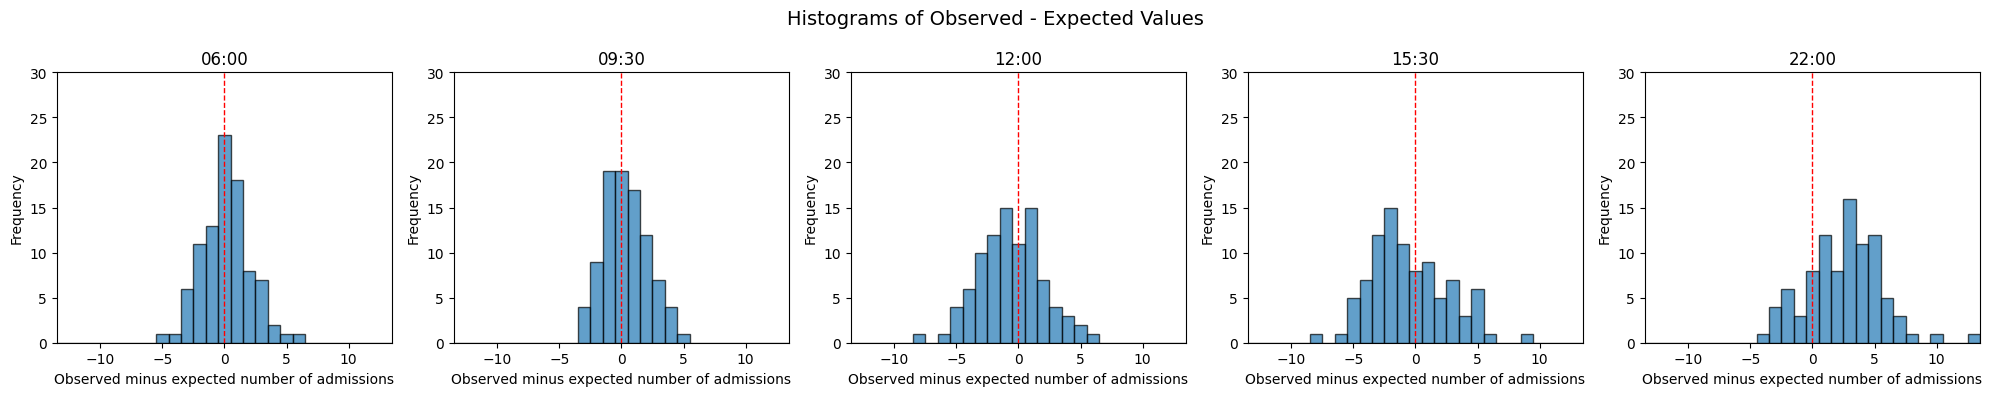

In [29]:
from patientflow.viz.evaluation_plots import plot_observed_against_expected
plot_observed_against_expected(results)

### 2c. QQ Plots

A  qq plot compares a predicted distribution to an observed distribution. In this case, the predicted distribution is the combined set of probability distributions (one for each snapshot date in the test set) at the given prediction time. The observed distribution is derived from the actual number of patients who were later admitted in each of those snapshot dates. 

If the predicted and observed distributions are similar, the qq plot should adhere closely to the y = x line in the plot. 


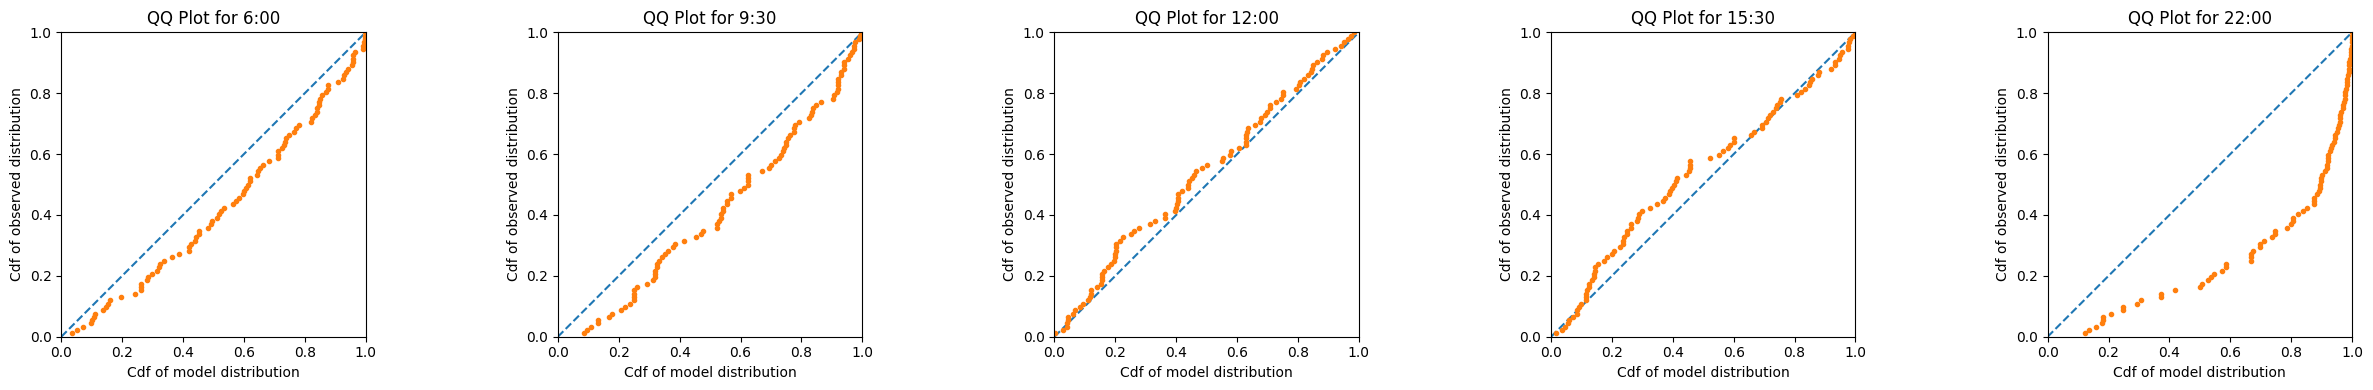

In [31]:
from patientflow.viz.qq_plot import qq_plot

qq_plot(prediction_times, 
        prob_dist_dict_all,
        model_name="admissions_balanced_calibrated")